## Colormaps

เมื่อคุณต้องการแยกความแตกต่างระหว่างพื้นที่ต่าง ๆ  
โดยไม่ต้องการสื่อถึงความสัมพันธ์เชิงลำดับหรือปริมาณใด ๆ  
การใช้ชุดสีแบบเชิงคุณภาพ (qualitative colormap) เป็นตัวเลือกที่เหมาะสมที่สุด

ในแบบฝึกหัดนี้ คุณจะเปรียบเทียบการใช้ชุดสีแบบเชิงคุณภาพกับชุดสีแบบลำดับค่า (sequential หรือ quantitative colormap) โดยใช้ GeoDataFrame ของเขตการศึกษา (`school_districts`)

In [1]:
import geopandas as gpd

school_districts = gpd.read_file('../../data/raw/school_districts.geojson')

school_districts.head()

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ..."
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ..."
2,Dr. Jo Ann,Nashville,37220,joann.brannon@mnps.org,TN,Brannon,5444 San Marcos Drive,Member,2018,2,615-833-5976,"MULTIPOLYGON (((-86.76696 36.08333, -86.7659 3..."
3,Anna,Hermitage,37076,anna.shepherd@mnps.org,TN,Shepherd,4545 Raccoon Trail,Chair,2018,4,615-210-3768,"MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ..."
4,Amy,Nashville,37221,amy.frogge@mnps.org,TN,Frogge,7237 Riverfront Drive,Member,2016,9,615-521-5650,"MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ..."


In [3]:
school_districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

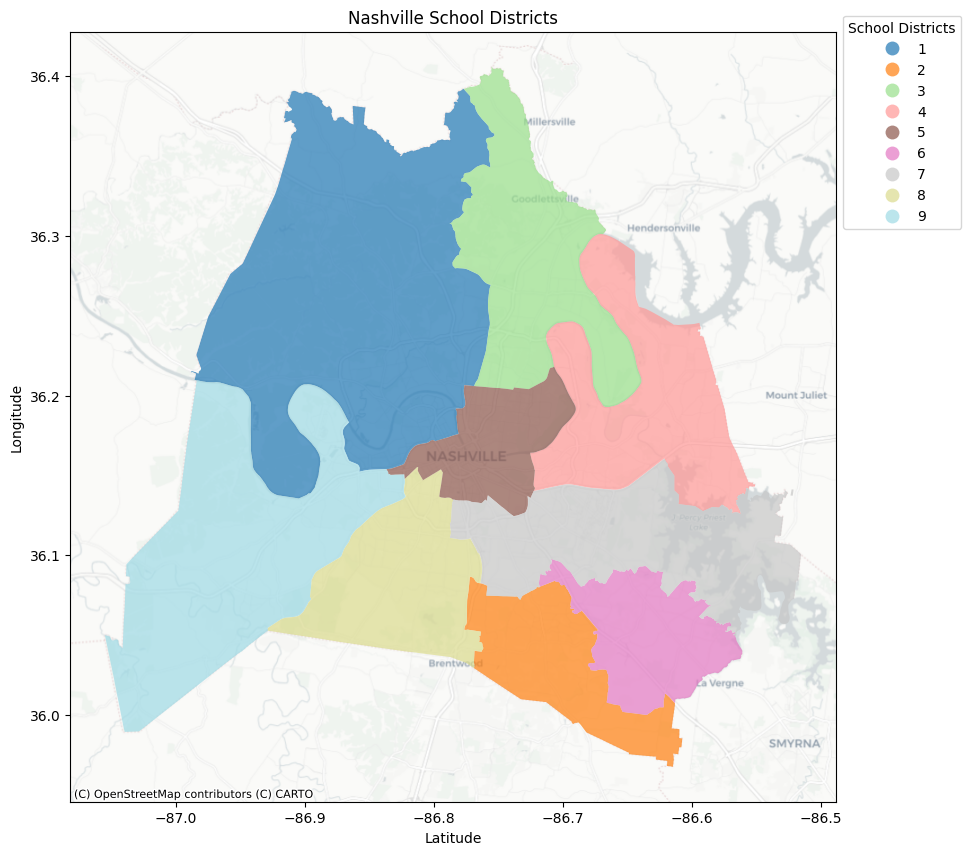

In [5]:
import matplotlib.pyplot as plt
import contextily as ctx
# Set legend style
lgnd_kwds = {'title': 'School Districts',
               'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 1}

# Plot the school districts using the tab20 colormap (qualitative)
school_districts.plot(column = 'district', cmap = 'tab20', legend = True, legend_kwds  = lgnd_kwds, alpha = 0.7, figsize=(10, 10))
ctx.add_basemap(plt.gca(), crs=school_districts.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Nashville School Districts')
plt.show();

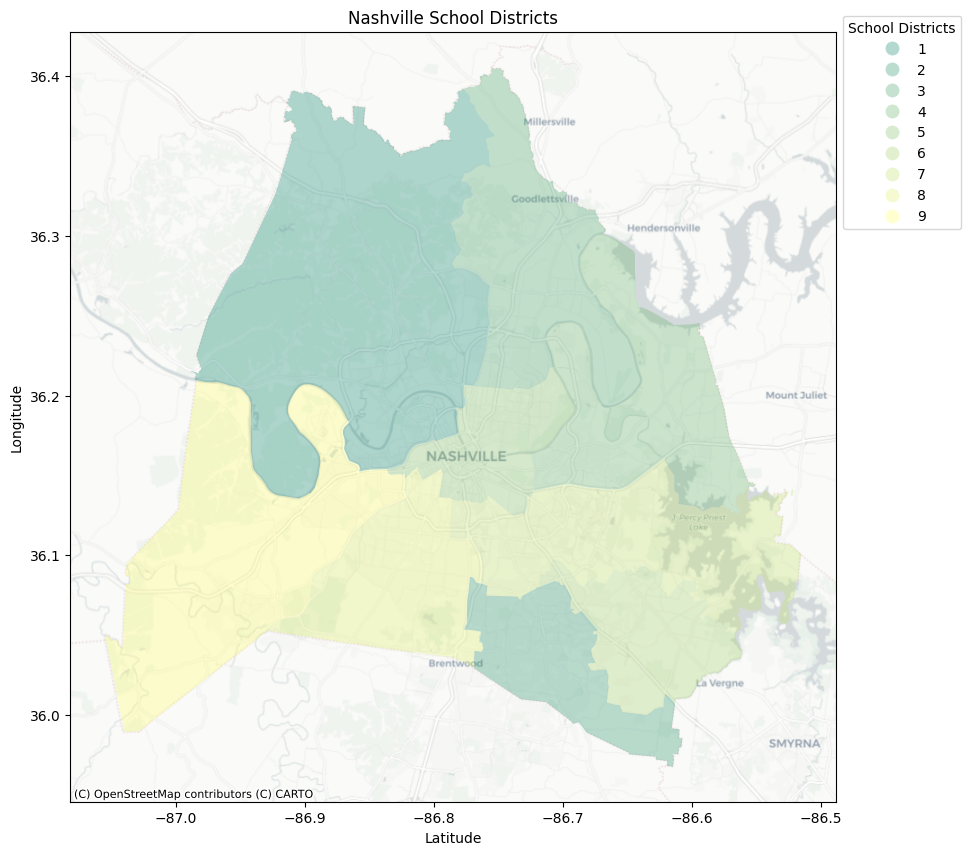

In [6]:
# Set legend style
lgnd_kwds = {'title': 'School Districts',
               'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 1}

# Plot the school districts using the summer colormap (sequential)
school_districts.plot(column = 'district', cmap = 'summer', legend = True, legend_kwds = lgnd_kwds, alpha = 0.3, figsize=(10, 10))
ctx.add_basemap(plt.gca(), crs=school_districts.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Nashville School Districts')
plt.show();

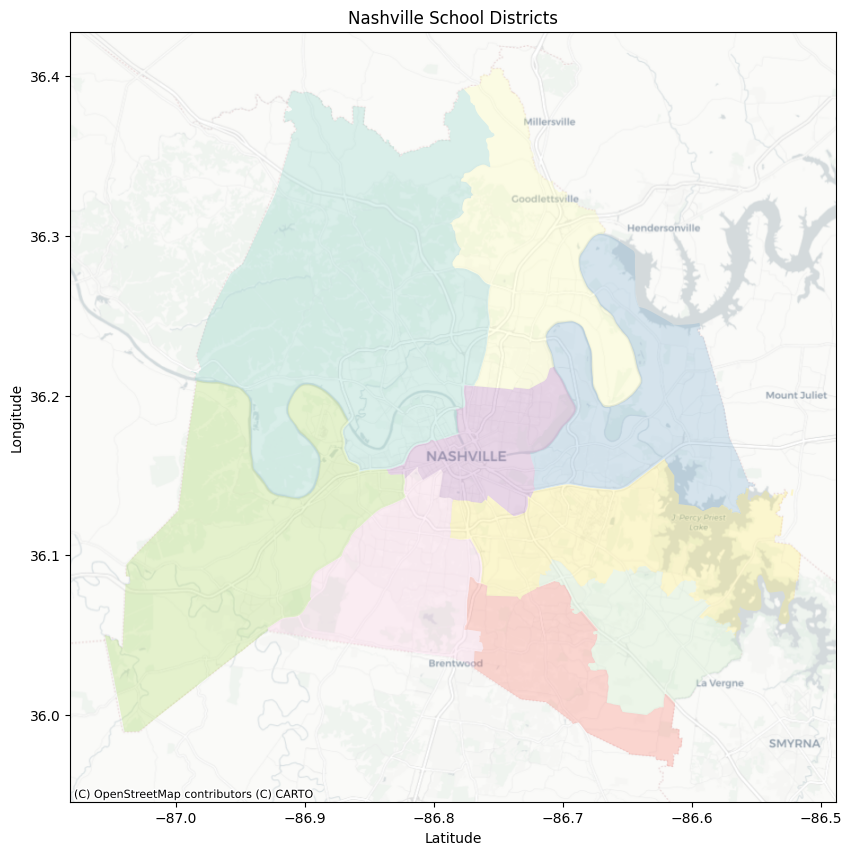

In [ ]:
# Set legend style
lgnd_kwds = {'title': 'School Districts',
               'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 1}

# Plot the school districts using Set3 colormap without the column argument
school_districts.plot(cmap = 'Set3', legend = True, legend_kwds  = lgnd_kwds, alpha = 0.3, figsize=(10, 10))
ctx.add_basemap(plt.gca(), crs=school_districts.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Nashville School Districts')
plt.show();

## แผนที่ย่านต่าง ๆ ในแนชวิลล์ (Nashville)

ในครั้งนี้ คุณจะอ่านไฟล์ GeoJSON เข้าสู่ GeoDataFrame  
เพื่อสำรวจตำแหน่งของย่านต่าง ๆ ในเมืองแนชวิลล์แบบคร่าว ๆ

In [9]:
# Read in the neighborhoods geojson file
neighborhoods = gpd.read_file('../../data/raw/neighborhoods.geojson')

# Print the first few rows of neighborhoods
neighborhoods.head()


,name,geometry
0,Historic Buena Vista,"MULTIPOLYGON (((-86.79511 36.17576, -86.79403 ..."
1,Charlotte Park,"MULTIPOLYGON (((-86.8746 36.15758, -86.87317 3..."
2,Hillwood,"MULTIPOLYGON (((-86.87614 36.13554, -86.87583 ..."
3,West Meade,"MULTIPOLYGON (((-86.90384 36.12554, -86.90328 ..."
4,White Bridge,"MULTIPOLYGON (((-86.86321 36.12886, -86.86321 ..."


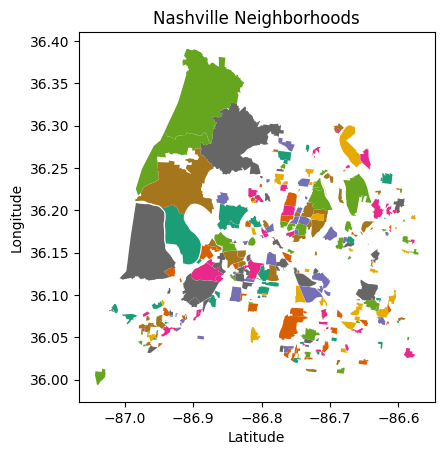

In [10]:
# Plot the neighborhoods, color according to name and use the Dark2 colormap
neighborhoods.plot(column = 'name', cmap = 'Dark2')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Nashville Neighborhoods')
# Show the plot.
plt.show()

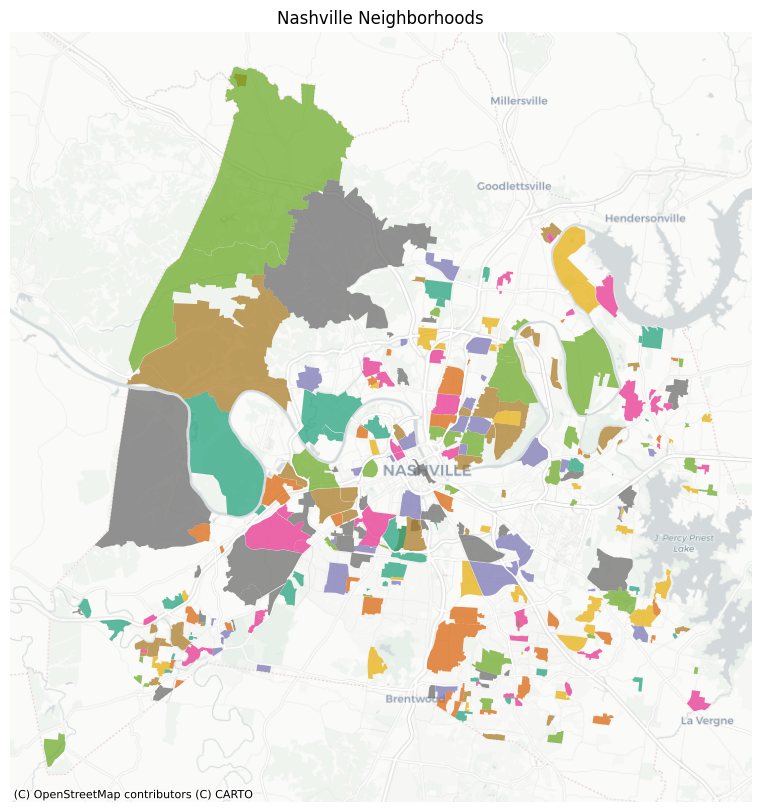

In [11]:
# แปลงเป็น Web Mercator
neigh_3857 = neighborhoods.to_crs(epsg=3857)

ax = neigh_3857.plot(column="name", cmap="Dark2", figsize=(10, 10), alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=neigh_3857.crs)

ax.set_axis_off()
ax.set_title("Nashville Neighborhoods")
plt.show()

## Changing coordinate reference systems


In [12]:
# Check the coordinate reference system (CRS) of the school districts 
print(school_districts.crs)

EPSG:4326


In [13]:
# Convert the crs to epsg:3857
school_districts = school_districts.to_crs(epsg=3857)
# Check the coordinate reference system (CRS) of the school districts again to confirm it has been converted
print(school_districts.crs)

EPSG:3857


## Construct a GeoDataFrame from a DataFrame

In [14]:
import pandas as pd
from shapely.geometry import Point

art = pd.read_csv('../../data/raw/public_art.csv')
art.head()

,Title,Last Name,First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location
0,[Cross Country Runners],Frost,Miley,"4001 Harding Rd., Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)"
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)"
2,12th & Porter Mural,Kennedy,Kim,114 12th Avenue N,Porter all-weather outdoor paint,Mural,Kim Kennedy is a musician and visual artist wh...,36.15790,-86.78817,"(36.1579, -86.78817)"
3,A Splash of Color,Stevenson and Stanley and ROFF (Harroff),Doug and Ronnica and Lynn,616 17th Ave. N.,"Steel, brick, wood, and fabric on frostproof c...",Mural,Painted wooden hoop dancer on a twenty foot po...,36.16202,-86.79975,"(36.16202, -86.79975)"
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)"


In [15]:
# Create a geometry column from the longitude and latitude columns
art['geometry'] = art.apply(lambda x: Point(float(x['Longitude']), float(x['Latitude'])), axis=1)

# Create a GeoDataFrame from the art DataFrame, using the geometry column and setting the CRS to neighborhoods CRS
art_gdf = gpd.GeoDataFrame(art, geometry='geometry', crs=neighborhoods.crs)
art_gdf.head()

,Title,Last Name,First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location,geometry
0,[Cross Country Runners],Frost,Miley,"4001 Harding Rd., Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)",POINT (-86.8366 36.12856)
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774 36.16234)
2,12th & Porter Mural,Kennedy,Kim,114 12th Avenue N,Porter all-weather outdoor paint,Mural,Kim Kennedy is a musician and visual artist wh...,36.15790,-86.78817,"(36.1579, -86.78817)",POINT (-86.78817 36.1579)
3,A Splash of Color,Stevenson and Stanley and ROFF (Harroff),Doug and Ronnica and Lynn,616 17th Ave. N.,"Steel, brick, wood, and fabric on frostproof c...",Mural,Painted wooden hoop dancer on a twenty foot po...,36.16202,-86.79975,"(36.16202, -86.79975)",POINT (-86.79975 36.16202)
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215)


In [16]:
# Check the coordinate reference system (CRS) of the art_gdf GeoDataFrame
print(art_gdf.crs)

EPSG:4326


## Spatial join practice

In [17]:
# Spatially join art_gdf to neighborhoods, using the 'intersects' predicate 
art_intersect_neighborhoods = gpd.sjoin(art_gdf, neighborhoods, predicate='intersects')
print(art_intersect_neighborhoods.shape)

(40, 13)


In [18]:
# Spatially join art_gdf to neighborhoods, using the 'within' predicate 
art_within_neighborhoods = gpd.sjoin(art_gdf, neighborhoods, predicate='within')
print(art_within_neighborhoods.shape)


(40, 13)


In [19]:
# Spatially join art_gdf to neighborhoods, using the 'contains' predicate 
art_contains_neighborhoods = gpd.sjoin(art_gdf, neighborhoods, predicate='contains')
print(art_contains_neighborhoods.shape)


(0, 13)


## การค้นหาย่านที่มีงานศิลปะสาธารณะมากที่สุด

ในขั้นตอนนี้ คุณจะวิเคราะห์ข้อมูลเพื่อค้นหาว่า  
ย่านใดในเมืองแนชวิลล์มีจำนวนผลงานศิลปะสาธารณะมากที่สุด

In [20]:
# Spatially join neighborhoods with art_gdf
neighborhoods_with_art = gpd.sjoin(art_gdf, neighborhoods, predicate='within')
neighborhoods_with_art.head()


,Title,Last Name,First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location,geometry,index_right,name
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774 36.16234),41,Urban Residents
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
5,Aerial Innovations Mural,Rudloff,Andee,202 South 17th St.,House paint on wood,Mural,NaN,36.17354,-86.73994,"(36.17354, -86.73994)",POINT (-86.73994 36.17354),13,Lockeland Springs
19,Building a Positive Community,"Healing Arts Project, Inc.",Healing Arts Project,East Park Community Center,interior wall paint on board,Mural,"The Healing Arts Project, Inc. sponsored the c...",36.17214,-86.76244,"(36.17214, -86.76244)",POINT (-86.76244 36.17214),15,Historic Edgefield
20,Can-Do,Lucking-Reilley,Mary,"Corner of 12th Ave S & Sevier Park, Nashville TN",Painted metal,Sculpture,Trash can created by artist and children,36.12161,-86.79027,"(36.12161, -86.79027)",POINT (-86.79027 36.12161),223,Sunnyside


## การรวมข้อมูลจุดภายในพื้นที่หลายเหลี่ยม (Aggregating Points Within Polygons)

เมื่อคุณได้ทำการเชื่อมข้อมูลเชิงพื้นที่ (spatial join) ระหว่างผลงานศิลปะและย่านต่าง ๆ แล้ว  
คุณสามารถจัดกลุ่ม (group), รวมค่า (aggregate) และเรียงลำดับ (sort) ข้อมูล  
เพื่อค้นหาว่าย่านใดมีงานศิลปะสาธารณะมากที่สุด

คุณสามารถนับจำนวนชื่อผลงานศิลปะ (artwork titles)  
เพื่อดูว่าแต่ละย่านมีผลงานศิลปะจำนวนกี่ชิ้น

In [21]:
# Get name and title from neighborhood_art and group by name
neighborhood_art_grouped = neighborhoods_with_art[['name', 'Title']].groupby('name')

# Aggregate the grouped data and count the artworks within each polygon
neighborhood_art_grouped.agg('count').sort_values(by = 'Title', ascending = False)

,Title
name,
Urban Residents,22
Lockeland Springs,3
Edgehill (ONE),2
Germantown,2
Hillsboro-West End,2
Inglewood,2
Sunnyside,2
Chestnut Hill (TAG),1
Historic Edgefield,1


## การพล็อตย่าน Urban Residents และผลงานศิลปะ

ตอนนี้คุณทราบแล้วว่างานศิลปะส่วนใหญ่อยู่ในย่าน **Urban Residents**

ในแบบฝึกหัดนี้ คุณจะสร้างแผนที่แสดงผลงานศิลปะภายในย่านดังกล่าว โดยมีขั้นตอนดังนี้:

1. เลือกเฉพาะข้อมูลผลงานศิลปะในย่าน Urban Residents จาก `neighborhood_art` แล้วเก็บไว้ในตัวแปร `urban_art`
2. เลือกเฉพาะ polygon ของย่าน Urban Residents จาก `neighborhoods` แล้วเก็บไว้ในตัวแปร `urban_polygon`
3. พล็อต polygon ก่อน และกำหนดให้เป็นแกน `ax`
4. จากนั้นเพิ่มการพล็อตจุดผลงานศิลปะลงบนแผนที่เดียวกัน

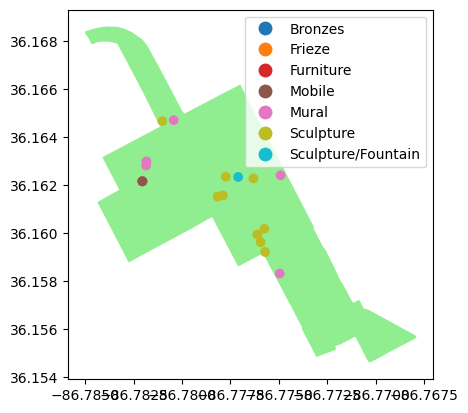

In [22]:
# Create urban_art from neighborhood_art where the neighborhood name is Urban Residents
urban_art = neighborhoods_with_art.loc[neighborhoods_with_art['name'] == 'Urban Residents']

# Get just the Urban Residents neighborhood polygon and save it as urban_polygon
urban_polygon = neighborhoods.loc[neighborhoods['name'] == "Urban Residents"]

# Plot the urban_polygon as ax 
ax = urban_polygon.plot(color = 'lightgreen')

# Add a plot of the urban_art and show it
urban_art.plot( ax = ax, column = 'Type', legend = True)
plt.show()

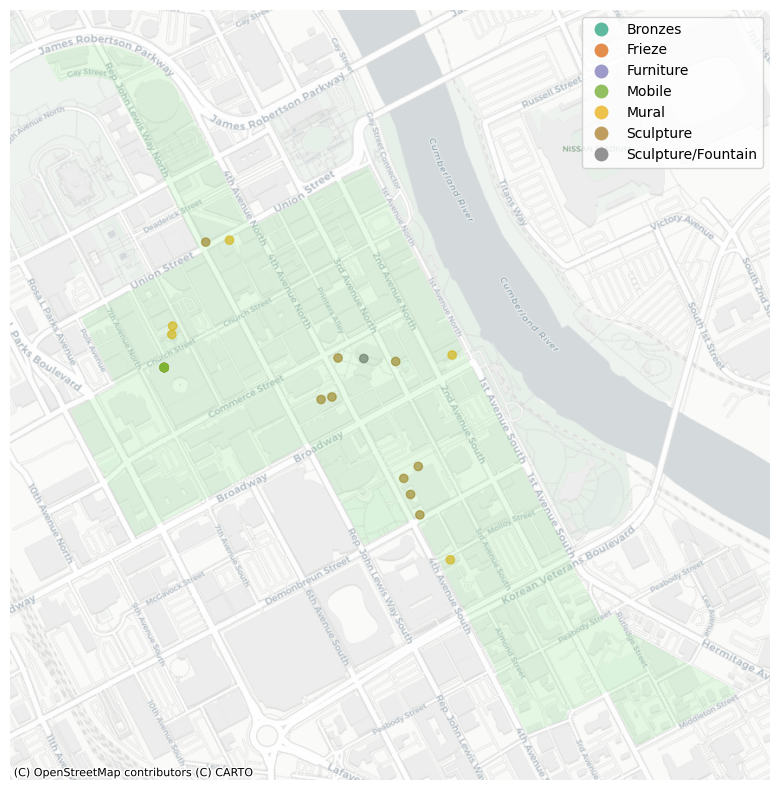

In [23]:
# แปลงเป็น Web Mercator
urban_art_3857 = urban_art.to_crs(epsg=3857)
urban_polygon_3857 = urban_polygon.to_crs(epsg=3857)

ax = urban_art_3857.plot(column="Type", cmap="Dark2", figsize=(10, 10), alpha=0.7, legend = True)
urban_polygon_3857.plot(ax=ax, color='lightgreen', alpha=0.2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=urban_art_3857.crs)

ax.set_axis_off()
plt.show()